In [1]:
!git clone https://github.com/hungpham13/Face-mask-detection.git

Cloning into 'Face-mask-detection'...
remote: Enumerating objects: 1726, done.
remote: Total 1726 (delta 0), reused 0 (delta 0), pack-reused 1726
Receiving objects: 100% (1726/1726), 395.15 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (854/854), done.


## Import required libraries

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler, RandomSampler
from torch.utils.data import Subset

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install opencv-python-headless==4.1.2.30
import albumentations as A
from albumentations.augmentations.dropout import functional as AF
from albumentations.pytorch import ToTensorV2
import cv2

import time
from pprint import PrettyPrinter
from bs4 import BeautifulSoup
import os
from pathlib import Path
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from torchvision.utils import save_image
import torchvision.transforms.functional as F
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from google.colab import drive
drive.mount('/content/drive')

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-an92xxx6
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-an92xxx6
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112536 sha256=9b94ecba64c19d4ea484b995c160b673859bec9e2f776641eadc7c896aeeaf02
  Stored in directory: /tmp/pip-ephem-wheel-cache-02mdo87d/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 21.8 MB 1.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:


In [3]:
# Global variables
annotation_dir = "./Face-mask-detection/data/annotations/"
image_dir = "./Face-mask-detection/data/images/"

LABELS = ['without_mask', #0
          'mask_weared_incorrect', #1
          'with_mask' #2
          ] 

## Prepare data for Pytorch - Extract data from XML files

- img: transformed RGB image
- annotation: dictionary
    - boxes: tensor which each row is a box `[xmin, ymin, xmax, ymax]`
    - labels: tensor which each row is class corresponding to box
    - image_id: tensor with image number

In [4]:
def clamp(x, min_val, max_val):
    '''Clamps input x into the range [min, max]'''
    return min(max(x,min_val),max_val)
def get_annotation(xml_file):
    with open(xml_file) as f:
        soup = BeautifulSoup(f.read(), 'xml')
        objects = soup.find_all('object')
        width = int(soup.find('width').text)
        height = int(soup.find('height').text)

        boxes,label_int = [],[]
        info = {}
        for obj in objects:
            label_int.append(LABELS.index(obj.find('name').text))
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)
            # ensure box is not lie outside the image
            boxes.append([clamp(xmin,0,width), 
                          clamp(ymin,0,height),
                          clamp(xmax,0,width),
                          clamp(ymax,0,height)
                          ])
        # convert to tensor
        info['boxes'] = torch.as_tensor(boxes, dtype = torch.float32)
        info['labels'] = torch.as_tensor(label_int, dtype = torch.int64)
        return info

class MaskDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.imgs = sorted([n for (d,_,n) in os.walk(image_dir)][0])
        self.to_tensor = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self,idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(image_dir, file_image)
        label_path = os.path.join(annotation_dir, file_label)
        img = Image.open(img_path).convert("RGB")

        #Get Label
        label = get_annotation(label_path)
        label['image_id'] = torch.tensor([idx])
        if self.transform:
            transformed = self.transform(image = np.array(img),
                                         bboxes = np.array(label['boxes']),
                                         class_labels = np.array(label['labels']))
            img = transformed['image']
            label['boxes'] = torch.as_tensor(transformed['bboxes'],dtype = torch.float32)
            label['labels'] = torch.as_tensor(transformed['class_labels'],dtype = torch.int64)
        return self.to_tensor(img), label

    def __len__(self):
        return len(self.imgs)

Check the class distribution in original dataset

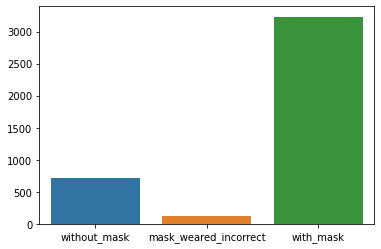

In [5]:
def unzip_batch(batch):
    '''unzip the batch to individual pairs
    from (img1,img2,..),(label1,label2,...) to (img1,label1),(img2,label2),....
    '''
    return list(zip(*batch))

def plot_class_dist(data_loader,title=""):
    x = []
    for imgs, annotations in data_loader:
        x.extend([a['labels'] for a in annotations])
    instances_num = (torch.bincount(torch.cat(x)).tolist())
    sns.barplot(x=LABELS,y=instances_num).set_title(title)
    return instances_num

class_num = plot_class_dist(DataLoader(MaskDataset(), collate_fn = unzip_batch))

As you can see, number instances in each class are highly imbalance, we will perform some augmentation to tackle this problem

### Data augmentation

In [6]:
# Source code from Albumentation library, I modified it to compatible with object detection problem
import random
from typing import Tuple, Iterable


class GridDropout(A.DualTransform):
    """GridDropout, drops out rectangular regions of an image and the corresponding mask in a grid fashion.
    Args:
        ratio (float): the ratio of the mask holes to the unit_size (same for horizontal and vertical directions).
            Must be between 0 and 1. Default: 0.5.
        unit_size_min (int): minimum size of the grid unit. Must be between 2 and the image shorter edge.
            If 'None', holes_number_x and holes_number_y are used to setup the grid. Default: `None`.
        unit_size_max (int): maximum size of the grid unit. Must be between 2 and the image shorter edge.
            If 'None', holes_number_x and holes_number_y are used to setup the grid. Default: `None`.
        holes_number_x (int): the number of grid units in x direction. Must be between 1 and image width//2.
            If 'None', grid unit width is set as image_width//10. Default: `None`.
        holes_number_y (int): the number of grid units in y direction. Must be between 1 and image height//2.
            If `None`, grid unit height is set equal to the grid unit width or image height, whatever is smaller.
        shift_x (int): offsets of the grid start in x direction from (0,0) coordinate.
            Clipped between 0 and grid unit_width - hole_width. Default: 0.
        shift_y (int): offsets of the grid start in y direction from (0,0) coordinate.
            Clipped between 0 and grid unit height - hole_height. Default: 0.
        random_offset (boolean): weather to offset the grid randomly between 0 and grid unit size - hole size
            If 'True', entered shift_x, shift_y are ignored and set randomly. Default: `False`.
        fill_value (int): value for the dropped pixels. Default = 0
        mask_fill_value (int): value for the dropped pixels in mask.
            If `None`, transformation is not applied to the mask. Default: `None`.
    Targets:
        image, mask
    Image types:
        uint8, float32
    References:
        https://arxiv.org/abs/2001.04086
    """

    def __init__(
        self,
        ratio: float = 0.5,
        unit_size_min: int = None,
        unit_size_max: int = None,
        holes_number_x: int = None,
        holes_number_y: int = None,
        shift_x: int = 0,
        shift_y: int = 0,
        random_offset: bool = False,
        fill_value: int = 0,
        mask_fill_value: int = None,
        always_apply: bool = False,
        p: float = 0.5,
    ):
        super(GridDropout, self).__init__(always_apply, p)
        self.ratio = ratio
        self.unit_size_min = unit_size_min
        self.unit_size_max = unit_size_max
        self.holes_number_x = holes_number_x
        self.holes_number_y = holes_number_y
        self.shift_x = shift_x
        self.shift_y = shift_y
        self.random_offset = random_offset
        self.fill_value = fill_value
        self.mask_fill_value = mask_fill_value
        if not 0 < self.ratio <= 1:
            raise ValueError("ratio must be between 0 and 1.")

    def apply(self, img: np.ndarray, holes: Iterable[Tuple[int, int, int, int]] = (), **params) -> np.ndarray:
        return AF.cutout(img, holes, self.fill_value)

    def apply_to_bbox(self, bbox, **params):
        return bbox

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]
        # set grid using unit size limits
        if self.unit_size_min and self.unit_size_max:
            if not 2 <= self.unit_size_min <= self.unit_size_max:
                raise ValueError("Max unit size should be >= min size, both at least 2 pixels.")
            if self.unit_size_max > min(height, width):
                raise ValueError("Grid size limits must be within the shortest image edge.")
            unit_width = random.randint(self.unit_size_min, self.unit_size_max + 1)
            unit_height = unit_width
        else:
            # set grid using holes numbers
            if self.holes_number_x is None:
                unit_width = max(2, width // 10)
            else:
                if not 1 <= self.holes_number_x <= width // 2:
                    raise ValueError("The hole_number_x must be between 1 and image width//2.")
                unit_width = width // self.holes_number_x
            if self.holes_number_y is None:
                unit_height = max(min(unit_width, height), 2)
            else:
                if not 1 <= self.holes_number_y <= height // 2:
                    raise ValueError("The hole_number_y must be between 1 and image height//2.")
                unit_height = height // self.holes_number_y

        hole_width = int(unit_width * self.ratio)
        hole_height = int(unit_height * self.ratio)
        # min 1 pixel and max unit length - 1
        hole_width = min(max(hole_width, 1), unit_width - 1)
        hole_height = min(max(hole_height, 1), unit_height - 1)
        # set offset of the grid
        if self.shift_x is None:
            shift_x = 0
        else:
            shift_x = min(max(0, self.shift_x), unit_width - hole_width)
        if self.shift_y is None:
            shift_y = 0
        else:
            shift_y = min(max(0, self.shift_y), unit_height - hole_height)
        if self.random_offset:
            shift_x = random.randint(0, unit_width - hole_width)
            shift_y = random.randint(0, unit_height - hole_height)
        holes = []
        for i in range(width // unit_width + 1):
            for j in range(height // unit_height + 1):
                x1 = min(shift_x + unit_width * i, width)
                y1 = min(shift_y + unit_height * j, height)
                x2 = min(x1 + hole_width, width)
                y2 = min(y1 + hole_height, height)
                holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return (
            "ratio",
            "unit_size_min",
            "unit_size_max",
            "holes_number_x",
            "holes_number_y",
            "shift_x",
            "shift_y",
            "mask_fill_value",
            "random_offset",
        )

- Create the dataset
- Split the dataset to 20% validation and 80% training set


In [7]:
#weighted function for sampling, image with low class of 0 and 1 has higher weight
def get_weight(labels):
    num = torch.bincount(labels,minlength=3)
    freq = num/num.sum()
    return 0.7*freq[1]+0.29*freq[0]+0.01*freq[2]

get_weight(torch.tensor([1,1,1,1]))

tensor(0.7000)

In [8]:
train_transform = A.Compose([
                    #    A.RandomCrop(width=450, height=450), 
                       A.HorizontalFlip(p=0.5),  
                       A.Rotate(limit=25, p=0.5), 
                       A.Perspective(scale=(0.05, 0.1), fit_output=True, p=0.5),
                    #    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
                       A.RandomBrightnessContrast(p=0.5),
                       GridDropout(ratio=0.2,p=0.1),
], bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.3, label_fields=['class_labels']))


batch_size = 4
validation_split = .2
num_workers = 2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(MaskDataset())
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = Subset(MaskDataset(train_transform),train_indices)
val_dataset = Subset(MaskDataset(),val_indices)

# Creating PT data samplers and loaders:
weights = torch.cat([get_weight(a['labels']).unsqueeze(0) for i,a in train_dataset])
train_sampler = WeightedRandomSampler(weights, len(weights))
val_sampler = RandomSampler(val_dataset)

train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, num_workers=num_workers, collate_fn=unzip_batch)
test_loader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size, num_workers=num_workers, collate_fn=unzip_batch)

By applying different augmentation techiniques, we achive richer training dataset. Note that this apply to only training set, not validation set

[1107, 347, 1240]

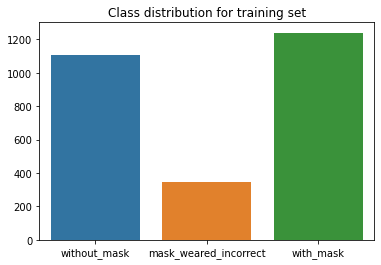

In [9]:
plot_class_dist(train_loader,title="Class distribution for training set")

[171, 23, 677]

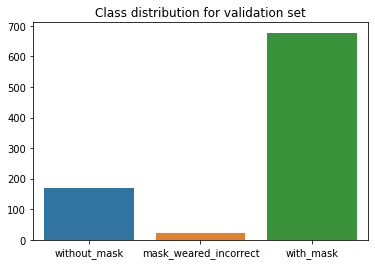

In [10]:
plot_class_dist(test_loader,title="Class distribution for validation set")

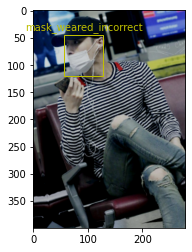

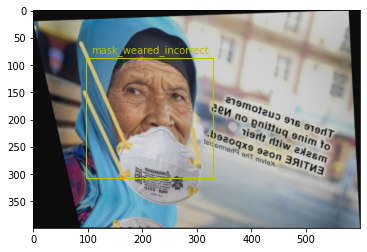

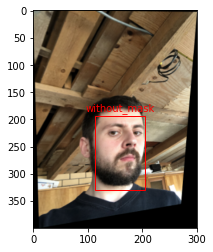

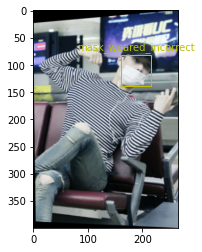

In [11]:
def plot_image(img_tensor, annotation):
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    # int to label and color
    COLORS = ['r','y','g']

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    for i,box in enumerate(annotation['boxes']):
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        index = int(annotation['labels'][i])
        label, color = LABELS[index], COLORS[index]
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')
        ax.annotate(label,color=color,
                    xy = (xmin+(xmax-xmin)/2,ymin), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 8), 
                    textcoords = 'offset points')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


img_batch, label_batch = next(iter(train_loader))

for img,label in zip(img_batch,label_batch):
    # print(img)
    # print(f"Feature batch shape: {img.size()}")
    # print(f"Labels batch : {label}")
    plot_image(img, label)

# Evaluation function

In [12]:
class Evaluator(object):
    def __init__(self):
        self.det_boxes = []
        self.det_labels = []
        self.det_scores = []
        self.true_boxes = []
        self.true_labels = []
    def update(self, targets, outputs):
        """extend a set of targets and outputs to evaluation data"""
        for output in outputs:
            self.det_boxes.append(output['boxes'])
            self.det_labels.append(output['labels'])
            self.det_scores.append(output['scores'])
        for target in targets:
            self.true_boxes.append(target['boxes'])
            self.true_labels.append(target['labels'])
    def summarize(self):
        int_to_label = {0:'without_mask',1:'mask_weared_incorrect',2:'with_mask'}
        APs, mAP = calculate_mAP(self.det_boxes, self.det_labels, self.det_scores, self.true_boxes, self.true_labels)
        # Print AP for each class
        pp = PrettyPrinter()
        pp.pprint({int_to_label[c]: v for c, v in enumerate(APs.tolist())})
        # Good formatting when printing the APs for each class and mAP
        print('\nMean Average Precision (mAP): %.3f' % mAP)

In [13]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """
    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)
    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)
    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)
    return intersection / union  # (n1, n2)

In [14]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, n_classes =3, iou_thres=0.5):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    true_difficulties = [torch.zeros(len(b)) for b in true_boxes]
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(true_labels) == len(true_difficulties) 
    # these are all lists of tensors of the same length, i.e. number of images

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes), dtype=torch.float)  # (n_classes)
    for c in range(n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which TRUE objects with THIS class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)

        # for each image in this class
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > iou_thres:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c] = precisions.mean()  # c is in [0, n_classes-1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    return average_precisions, mean_average_precision

# Build model
- Faster RCNN
- YOLO

In [15]:
# Helper function

def save(epoch, model, optimizer, cp="cp1"):
    PATH = f'/content/drive/My Drive/{cp}'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

def load(PATH, model, optimizer):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

### Approach 1: Faster R-CNN

> The models expect a list of `Tensor[C, H, W]`, in the range `0-1`. The models internally resize the images but the behaviour varies depending on the model. Check the constructor of the models for more information. The output format of such models is illustrated in Instance segmentation models

...

>Here are the summary of the accuracies for the models trained on the instances set of COCO train2017 and evaluated on COCO val2017.

<table class="docutils align-default">
<colgroup>
<col style="width: 59%">
<col style="width: 11%">
<col style="width: 13%">
<col style="width: 17%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>box AP</p></th>
<th class="head"><p>mask AP</p></th>
<th class="head"><p>keypoint AP</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>Faster R-CNN ResNet-50 FPN</p></td>
<td><p>37.0</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-odd"><td><p>Faster R-CNN MobileNetV3-Large FPN</p></td>
<td><p>32.8</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-even"><td><p>Faster R-CNN MobileNetV3-Large 320 FPN</p></td>
<td><p>22.8</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-odd"><td><p>RetinaNet ResNet-50 FPN</p></td>
<td><p>36.4</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-even"><td><p>SSD300 VGG16</p></td>
<td><p>25.1</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-odd"><td><p>SSDlite320 MobileNetV3-Large</p></td>
<td><p>21.3</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
<tr class="row-even"><td><p>Mask R-CNN ResNet-50 FPN</p></td>
<td><p>37.9</p></td>
<td><p>34.6</p></td>
<td><ul class="simple">
<li></li>
</ul>
</td>
</tr>
</tbody>
</table>

In [16]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [17]:
# model = get_model_instance_segmentation(3)
# images,targets = next(iter(train_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets) # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# get the model using our helper function
model = get_model_instance_segmentation(3)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [19]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    print("Start training epoch",epoch)
    model.train()
    epoch_loss = 0
    training_time = time.time()
    for i, (imgs, annotations) in enumerate(data_loader):
        # change device
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        #calc the loss
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        #reset gradient
        optimizer.zero_grad()
        #calc gradient
        losses.backward()
        #update weight
        optimizer.step()
        # print(f'Iteration: {i}/{len(data_loader)}, Loss: {losses}')
        epoch_loss += losses
    training_time = time.time() - training_time
    print(f"Epoch {epoch} - Training loss: {epoch_loss/len(data_loader)}")
    print(f"Epoch {epoch} - Training time: {training_time}")

def evaluate(model, data_loader, device):
    valid_loss = 0
    cpu_device = torch.device("cpu")
    evaluator = Evaluator()
    model.eval()
    with torch.no_grad():
        for imgs, targets in data_loader:
            # change device
            imgs = list(img.to(device) for img in imgs)

            model_time = time.time()
            outputs = model(imgs)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            model_time = time.time() - model_time
            evaluator.update(targets,outputs)
            # print(f"Evaluation time: {model_time}")
            # print(outputs)
            # res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            # print(res)
        evaluator.summarize()

In [20]:
def train(cont=False,cp=None):
    num_epochs = 25
    epoch = 0
    while epoch < num_epochs:
        if cont:
            load("/content/drive/My Drive/"+cp,model,optimizer)
            print("Continue at epoch",epoch)
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, test_loader, device=device)
        #update parameter
        epoch +=1
        cont=False
        #save the model
        save(epoch,model,optimizer)

In [21]:
# train()
# train(cont=True,cp="cp1")

## Approach 2: YOLO
Version: YOLO v5

Here's what we'll go over:

- Build a custom dataset in YOLO/darknet format
- Learn about YOLO model family history
- Fine-tune the largest YOLO v5 model
- Evaluate the model
- Look at some predictions and save the model

### Build the dataset
YOLO v5 requires the dataset to be in the *darknet format*. Here's an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: `class_index x_center y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1

Let's create a helper function that builds a dataset in the correct format for us:

In [22]:
def dataloader_to_darknet(data_loader, dataset_type, labels=LABELS):
    assert dataset_type in ('train','val')

    images_path = Path(yolo_img_dir + dataset_type)
    images_path.mkdir(parents=True, exist_ok=True)

    labels_path = Path(yolo_label_dir + dataset_type)
    labels_path.mkdir(parents=True, exist_ok=True)

    i = 0  #image index

    for imgs, annotations in data_loader:
        for img, annot in zip(imgs, annotations):
            #Save image to folder
            save_image(img,images_path / f"{i}.png")

            #Save annotation file
            with (labels_path / f"{i}.txt").open(mode="w") as label_file:
                #get the size of the image
                img_w, img_h = F.get_image_size(img)
                for box_num, box in enumerate(annot['boxes']):
                    # get box coordinate and convert it to yolo format
                    box_w, box_h = (box[2]-box[0])/img_w, (box[3]-box[1])/img_h
                    label_file.write(
                        f"{annot['labels'][box_num]} {box[0]/img_w + box_w/2} {box[1]/img_h + box_h/2} {box_w} {box_h}\n"
                    )
            i += 1

In [23]:
yolo_label_dir = "./facemask/labels/"
yolo_img_dir="./facemask/images/"
dataloader_to_darknet(train_loader,'train')
dataloader_to_darknet(test_loader,'val')

### Fine-tuning YOLO v5

The YOLO abbreviation stands for You Only Look Once. YOLO models are one stage object detectors. 

YOLO models are very light and fast. They are [not the most accurate object detections around](https://paperswithcode.com/sota/object-detection-on-coco), though. Ultimately, those models are the choice of many (if not all) practitioners interested in [real-time object detection (FPS >30)](https://paperswithcode.com/sota/real-time-object-detection-on-coco).

### Contreversy

Joseph Redmon introduced YOLO v1 in the 2016 paper [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf). The implementation uses the [Darknet Neural Networks library](https://pjreddie.com/darknet/).

He also co-authored the YOLO v2 paper in 2017  [YOLO9000: Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf). A significant improvement over the first iteration with much better localization of objects.

The final iteration, from the original author, was published in the 2018 paper [YOLOv3: An Incremental Improvement](https://arxiv.org/pdf/1804.02767.pdf).

Then things got a bit wacky. Alexey Bochkovskiy published [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934) on April 23, 2020. The project has [an open-source repository on GitHub](https://github.com/AlexeyAB/darknet).

YOLO v5 got open-sourced on [May 30, 2020](https://github.com/ultralytics/yolov5/commit/1e84a23f38fad9e52b59101e9f1246d93066ed1e) by [Glenn Jocher](https://github.com/glenn-jocher) from ultralytics. There is no published paper, but [the complete project is on GitHub](https://github.com/ultralytics/yolov5).

The community at Hacker News got into a [heated debate about the project naming](https://news.ycombinator.com/item?id=23478151). Even the guys at Roboflow wrote [Responding to the Controversy about YOLOv5](https://blog.roboflow.ai/yolov4-versus-yolov5/) article about it. They also did a great comparison between YOLO v4 and v5.


### YOLO v5 project setup

YOLO v5 uses PyTorch, but everything is abstracted away. You need the project itself (along with the required dependencies).

Let's start by cloning the GitHub repo and checking out a specific commit (to ensure reproducibility):

Let's start by installing some required libraries by the YOLOv5 project:

In [24]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5 
%pip install -qr requirements.txt  # install
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.4/78.2 GB disk)


We'll also install [Apex by NVIDIA](https://nvidia.github.io/apex/) to speed up the training of our model:

In [25]:
# !git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Create data yaml file

In [26]:
with open("data/facemask.yaml","w") as f:
    f.write(f"\
train: .{yolo_img_dir}train\n\
val: .{yolo_img_dir}val\n\
\n\
nc: 3\n\
names: {LABELS}\
")

Config the model yaml file: 
- change the number of classes to 3

In [27]:
#read the file
with open("models/yolov5x.yaml","r") as f:
    data = f.readlines()
#edit line 4: change number of class to 3
data[3] = 'nc: 3 # number of classes\n'
print(data)

#write back the file
with open("models/yolov5x.yaml","w") as f:
    f.writelines(data)

['# YOLOv5 🚀 by Ultralytics, GPL-3.0 license\n', '\n', '# Parameters\n', 'nc: 3 # number of classes\n', 'depth_multiple: 1.33  # model depth multiple\n', 'width_multiple: 1.25  # layer channel multiple\n', 'anchors:\n', '  - [10,13, 16,30, 33,23]  # P3/8\n', '  - [30,61, 62,45, 59,119]  # P4/16\n', '  - [116,90, 156,198, 373,326]  # P5/32\n', '\n', '# YOLOv5 v6.0 backbone\n', 'backbone:\n', '  # [from, number, module, args]\n', '  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2\n', '   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4\n', '   [-1, 3, C3, [128]],\n', '   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8\n', '   [-1, 6, C3, [256]],\n', '   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16\n', '   [-1, 9, C3, [512]],\n', '   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32\n', '   [-1, 3, C3, [1024]],\n', '   [-1, 1, SPPF, [1024, 5]],  # 9\n', '  ]\n', '\n', '# YOLOv5 v6.0 head\n', 'head:\n', '  [[-1, 1, Conv, [512, 1, 1]],\n', "   [-1, 1, nn.Upsample, [None, 2, 'nearest']],\n", '   [[-1, 6], 1, Concat, [1]],  # cat backb

### Training

Fine-tuning an existing model is very easy. We'll use the largest model **YOLOv5x** (89M parameters), which is also the most accurate.

In our case, we don't really care about speed. We just want the best accuracy you can get. The checkpoint you're going to use for a different problem(s) is contextually specific. [Take a look at the overview of the pre-trained checkpoints](https://github.com/ultralytics/yolov5/blob/f9ae460eeccd30bdc43a89a37f74b9cc7b93d52f/README.md#pretrained-checkpoints).

To train a model on a custom dataset, we'll call the `train.py` script. We'll pass a couple of parameters:

- img_size: 640
- batch: 4
- epochs: 30
- data ./data/facemask.yaml - path to dataset config
- cfg ./models/yolov5x.yaml - model config
- weights yolov5x.pt - use pre-trained weights from the YOLOv5x model
- name yolov5x_facemask - name of our model
- cache - cache dataset images for faster training

In [28]:
!python train.py --img 640 --batch 4 --epochs 30 \
  --data ./data/facemask.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt \
  --name yolov5x_facemask --cache

train: weights=yolov5x.pt, cfg=./models/yolov5x.yaml, data=./data/facemask.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5x_facemask, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4

In [ ]:
from utils.plots import plot_results

In [38]:
plot_results('./runs/train/yolov5x_facemask/results.csv')

Copy validation images to `inference` folder

In [41]:
!find ../facemask/images/val/ -maxdepth 1 -type f | head -50 | xargs cp -t "./data/images/"

We'll use the `detect.py` script to run our model on the images. Here are the parameters we're using:

- weights weights/best_yolov5x_clothing.pt - checkpoint of the model
- img 640 - resize the images to 640x640 px
- conf 0.2 - take into account predictions with confidence of 0.4 or higher
- source ./inference/images/ - path to the images

In [43]:
!python detect.py --weights runs/train/yolov5x_facemask/weights/best.pt \
  --img 640 --conf 0.2 --source ./data/images/

detect: weights=['runs/train/yolov5x_facemask/weights/best.pt'], source=./data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 444 layers, 86186872 parameters, 0 gradients, 204.0 GFLOPs
image 1/52 /content/yolov5/data/images/101.png: 448x640 6 without_masks, 1 mask_weared_incorrect, 17 with_masks, Done. (0.077s)
image 2/52 /content/yolov5/data/images/106.png: 384x640 8 without_masks, 1 mask_weared_incorrect, 11 with_masks, Done. (0.048s)
image 3/52 /content/yolov5/data/images/111.png: 384x640 7 without_masks, 13 with_masks, Done. (0.037s)
image 

Save the model to file

In [44]:
%cp runs/train/yolov5x_facemask/weights/best.pt /content/drive/My\ Drive

# Material

Implementation of different architectures in Pytorch
- [R-CNN model in Pytorch - Github](https://github.com/jwyang/faster-rcnn.pytorch)
- [YoloV4 model in Pytorch- Github](https://github.com/Tianxiaomo/pytorch-YOLOv4/blob/master/models.py)
- [Pre-trained model in Pytorch - Pytorch official page](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
- [Data Augmentation, Optimization and ResNets in Pytoch - Jovian Notebooks](https://jovian.ai/aakashns/05b-cifar10-resnet)

Tutorial
- [Object Detection on Custom Dataset with YOLO (v5) Pytorch - Youtube](https://www.youtube.com/watch?v=XNRzZkZ-Byg)
- [R-CNN tutorial - ankur6ue's blog](https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns#Implementation_Details_Training)
- [EfficientNetV2 and CoAtNet - Google Blog](https://ai.googleblog.com/2021/09/toward-fast-and-accurate-neural.html?ref=refind)
- [A Gentle Introduction to Object Recognition With Deep Learning - ML web](https://machinelearningmastery.com/object-recognition-with-deep-learning/)
- [Get Shit done with Pytorch - Book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)
- [YoLO v4 on Webcam - Colab Notebook](https://colab.research.google.com/drive/1xdjyBiY75MAVRSjgmiqI7pbRLn58VrbE?usp=sharing#scrollTo=RPDr23YFW_7c)

Previous work
- https://colab.research.google.com/drive/1kR52KS008KfFNY7dDs7MXRyTBnDuhOPN#scrollTo=kRnIZitiNyyA

- https://github.com/bluewarrior-soda/Algorithm-Bootcamp-Scholarship/blob/main/Personal%20Projects/Deep%20Learning%20Final%20Project/notebooks/%231%20-%20Data%20Extraction.ipynb

Data source
- https://www.kaggle.com/andrewmvd/face-mask-detection


Tensorflow
- [Tensorflow beginner tutorial by freecodecamp]( https://www.freecodecamp.org/learn/machine-learning-with-python/tensorflow/neural-networks-creating-a-model)

